In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Unpickling the data

In [2]:
import pickle as pkl

with open('sensor_data_with_truth.pkl', 'rb') as f:
    e = pkl.load(f)
print(e)


{'accel': [array([7.90630326, 1.53488047, 3.91661982]), array([ 1.47307196, -4.23741118, -1.41526891]), array([-0.64599541,  0.79791078,  1.43878906]), array([ 1.15282069,  5.58333759, -7.73056893]), array([-4.38633954,  1.71337497, -1.12029176]), array([-0.73738171, -3.94077355, -1.69685383]), array([-10.30404875,   0.63079639,  -0.18143802]), array([-5.12112244,  0.68225934, -3.06849751]), array([-5.23915745,  4.553238  ,  7.78125988]), array([ 3.23983809, -0.75640046,  9.54537115]), array([ 2.06425923, -2.28951201, -1.21668004]), array([ 5.30257675, -4.01318678, -1.49112805]), array([-2.00054142, -6.02200332, -2.05205894]), array([ 3.63628242,  0.21851927, -7.34621943]), array([ 3.47887545,  1.11450479, -1.93000002]), array([-11.0298742 ,  -4.33565433,   2.09901649]), array([ 7.41758549, -2.08526964,  8.55290562]), array([ 3.82742091, -0.21757282, -1.52810247]), array([-4.48760567,  2.01791893,  1.05412802]), array([-2.58020138, 10.59363593, -0.4090027 ]), array([-1.2935113 ,  2.942

In [3]:
e.keys()


dict_keys(['accel', 'gyro', 'pressure', 'temp', 'gps', 'sensor_pos', 'rocket_pos'])

(5000, 3)


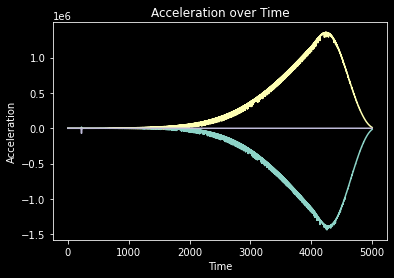

In [4]:
accel_sense = np.array(e['accel'])
print(accel_sense.shape)


# Plot accel over time
plt.plot(accel_sense)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration over Time')
plt.show()


(5000, 3)


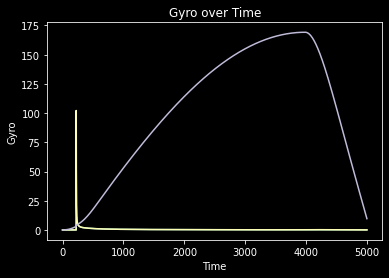

In [5]:
gyro_sense = np.array(e['gyro'])
print(gyro_sense.shape)

# Plot gyro over time
plt.plot(gyro_sense)
plt.xlabel('Time')
plt.ylabel('Gyro')
plt.title('Gyro over Time')
plt.show()


(5000,)


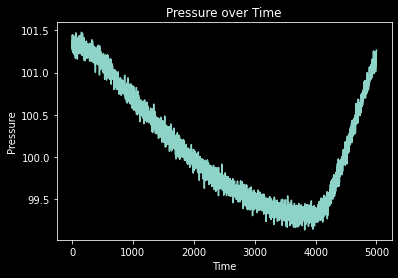

In [6]:
pressure_sense = np.array(e['pressure'])
print(pressure_sense.shape)

# Plot pressure over time
plt.plot(pressure_sense)
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title('Pressure over Time')
plt.show()


(5000,)


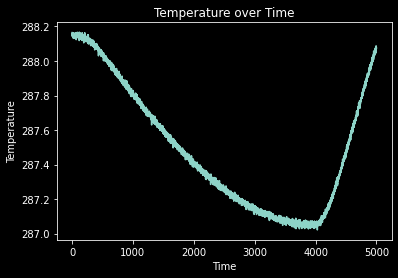

In [7]:
temp_sense = np.array(e['temp'])
print(temp_sense.shape)

# Plot temp over time
plt.plot(temp_sense)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show() 




In [8]:
baro_sense = np.vstack((np.array(e['pressure']), np.array(e['temp']))).T
baro_sense.shape


(5000, 2)

(5000, 3)


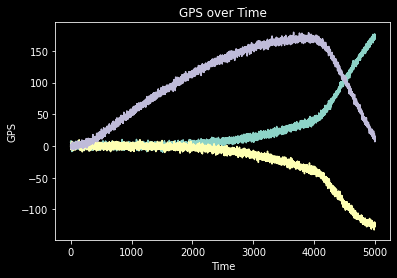

In [9]:
gps_sense = np.array(e['gps'])
print(gps_sense.shape)

# Plot gps over time
plt.plot(gps_sense)
plt.xlabel('Time')
plt.ylabel('GPS')
plt.title('GPS over Time')
plt.show() 


(5000, 3)


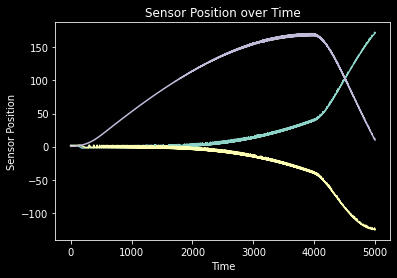

In [10]:
sensor_pos = np.array(e['sensor_pos'])
print(sensor_pos.shape)

# Plot sensor_pos over time
plt.plot(sensor_pos)
plt.xlabel('Time')
plt.ylabel('Sensor Position')
plt.title('Sensor Position over Time')
plt.show() 


(5000, 3)


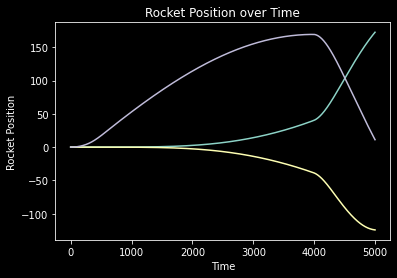

In [11]:
rocket_pos = np.array(e['rocket_pos'])
print(rocket_pos.shape)

# Plot rocket_pos over time
plt.plot(rocket_pos)
plt.xlabel('Time')
plt.ylabel('Rocket Position')
plt.title('Rocket Position over Time')
plt.show()


# Filtering the Data

In [12]:
import sys
sys.path.append("..")

from src.PredictorProvider import LinearPredictorProvider, UnscentedPredictorProvider
from src.CorrectorProvider import LinearCorrectorProvider, UnscentedCorrectorProvider


NUM_STATES = 16


## Evo Model

In [13]:
import quaternion

class BlackBoxPredictor(UnscentedPredictorProvider):
  def point_prop(self, state, dt):
    h_dt = dt**2 / 2

    pos = state[0:3]
    vel = state[3:6]
    accel = state[6:9]

    q = quaternion.as_quat_array(state[9:13, :].T)
    omega = state[13:16, :]

    
    pos_prime = pos + dt * vel + h_dt * accel
    vel_prime = vel + dt * accel
    accel_prime = accel

    rotated_q = quaternion.from_rotation_vector(dt * omega.T) * q

    q_prime = quaternion.as_float_array(rotated_q.T).T
    
    omega_prime = omega
    
    return np.concatenate((pos_prime, vel_prime, accel_prime, q_prime, omega_prime))



## Obs Models

In [14]:
class GPSCorrector(LinearCorrectorProvider):
  def linear_obs_mat(self):
    # The three vec of pos is what we observe
    return np.block([np.eye(3), np.zeros((3, 13))]) 


In [15]:
class BaroCorrector(UnscentedCorrectorProvider):
  def obs_pred(self, state):
    height = state[2, :]

    # Constants for the barometric formula
    g = 9.80665  # Acceleration due to gravity (m/s^2)
    M = 0.0289644  # Molar mass of Earth's air (kg/mol)
    R = 8.31432  # Universal gas constant (J/(mol*K))
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)

    # Calculate the temperature at the given height
    temperature = T0 - 0.0065 * height

    # Calculate the pressure using the barometric formula
    pressure = P0 * np.power((1 - (0.0065 * height) / T0), (g * M) / (R * 0.0065)) / 1e3

    return np.vstack((pressure, temperature))
  

In [16]:
IMU_RADIUS = np.array([[1.97144457, 1.47144457, 0.47144457]])

class AccelCorrector(UnscentedCorrectorProvider):
  def obs_pred(self, state):
    g = 9.80665  # Acceleration due to gravity (m/s^2)

    # accel includes gravity
    accel = state[6:9, :] - np.array([[0, 0, g]]).T
    
    q = quaternion.as_quat_array(state[9:13, :].T)
    omega = state[13:16, :]

    # Rotate the acceleration vector from global to the body frame
    body_accel = quaternion.as_vector_part(q.conjugate() * quaternion.from_vector_part(accel.T) * q)
    
    # Subtract the centripetal acceleration
    inner_cross = np.cross(omega.T, IMU_RADIUS)
    outer_cross = np.cross(omega.T, inner_cross)
    sensor_accel = body_accel - outer_cross
    
    return sensor_accel.T


In [17]:
test_corrector = AccelCorrector(np.eye(3), noise_lerp=0.0, num_states=NUM_STATES)

test_corrector.obs_pred(np.ones((NUM_STATES, 33))
).shape


(3, 33)

In [18]:
class OmegaCorrector(UnscentedCorrectorProvider):
  def obs_pred(self, state):
    q = quaternion.as_quat_array(state[9:13, :].T)
    omega = state[13:16, :]

    # Rotate the angular velocity vector from global to the body frame
    body_omega = quaternion.as_vector_part(q.conjugate() * quaternion.from_vector_part(omega.T) * q).T

    return body_omega


In [19]:
test_corrector = OmegaCorrector(np.eye(3), noise_lerp=0.0, num_states=NUM_STATES)

test_corrector.obs_pred(np.ones((NUM_STATES, 33))
).shape


(3, 33)

## Setting up the filter

In [38]:

process_noise = 1e-5 * np.eye(NUM_STATES)

gps_noise = np.diag(3 * np.ones(3, ))

baro_noise = np.diag(np.array((0.06, 0.01)))

g = 9.80665  # Acceleration due to gravity (m/s^2)
accel_noise = np.diag(g * 529000e-6 * np.ones(3, ))
gyro_noise = np.diag(0.00225 * np.pi / 180 * np.ones(3, ))

# Init the predictors and correctors
# Note: Noise lerp is sort of an abandoned experiment (the filter estimates the sensor and process cov based off of an exponential filter) 
# setting it to 0.0 means that the filter will use the provided noise matrices without modification
state_predictor = BlackBoxPredictor(process_noise, noise_lerp=0.0, num_states=NUM_STATES)

gps_corrector = GPSCorrector(gps_noise, noise_lerp=0.0)

baro_corrector = BaroCorrector(baro_noise, noise_lerp=0.0, num_states=NUM_STATES)
accel_corrector = AccelCorrector(accel_noise, noise_lerp=0.0, num_states=NUM_STATES)
omega_corrector = OmegaCorrector(gyro_noise, noise_lerp=0.0, num_states=NUM_STATES)


## Running the filter

In [39]:
dt = 0.01
total_time = 50

times = np.arange(0, total_time, dt)

starting_state = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0 ,0 ,0, 0, 0, 0])


In [40]:
state_history = np.zeros((NUM_STATES, len(times)))
cov_history = np.zeros((NUM_STATES, NUM_STATES, len(times)))

state = starting_state
# cov = np.random.rand(NUM_STATES, NUM_STATES)
# cov += cov.T 
# cov /= 1e3

# cov += np.eye(NUM_STATES) * 1e-7



cov = np.eye(NUM_STATES) * 1e-3

for ind, t in enumerate(times):
  print("ind: ", ind, end='\r')
  state, cov = state_predictor.predict(state, cov, dt)

  # state, cov = gps_corrector.correct(state, cov, gps_sense[ind, :], state_predictor)

  state, cov = baro_corrector.correct(state, cov, baro_sense[ind, :], state_predictor)

  # state, cov = accel_corrector.correct(state, cov, accel_sense[ind, :], state_predictor)

  # state, cov = omega_corrector.correct(state, cov, gyro_sense[ind, :], state_predictor)

  state_history[:, ind] = state
  cov_history[:, :, ind] = cov


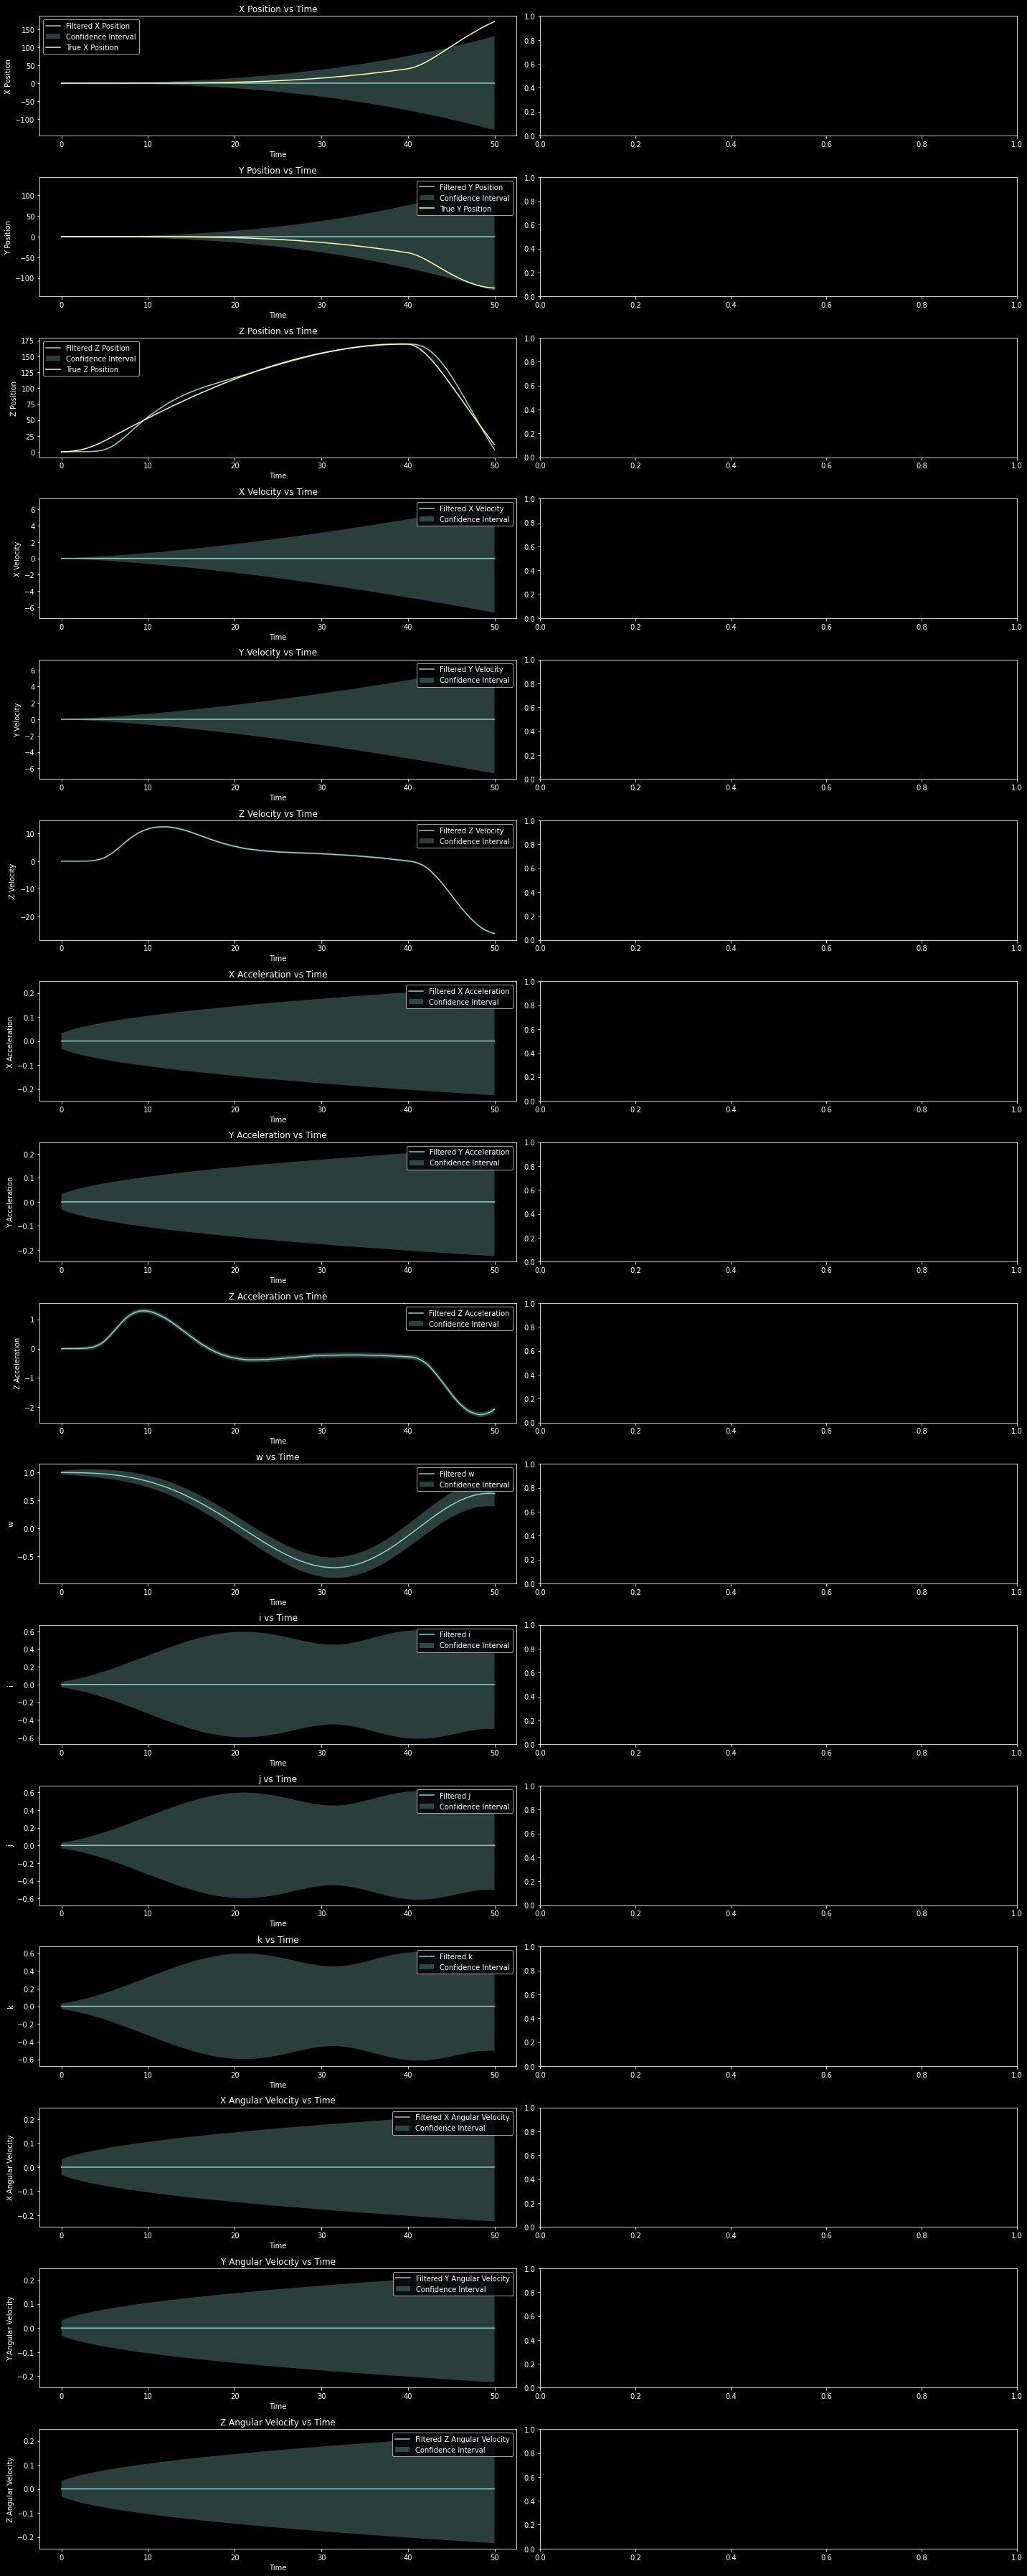

In [41]:
# Plotting position, velocity, acceleration, state variance, and residual over time
fig, axs = plt.subplots(3 * 3 + 4 + 3, 2, figsize=(20, 50))

for ind, label in enumerate(["X Position", "Y Position", "Z Position", "X Velocity", "Y Velocity", "Z Velocity", "X Acceleration", "Y Acceleration", "Z Acceleration", "w", "i", "j", "k", "X Angular Velocity", "Y Angular Velocity", "Z Angular Velocity"]):
  # Plotting position vs time
  axs[ind, 0].plot(times, state_history[ind, :], label='Filtered {}'.format(label))
  axs[ind, 0].fill_between(times, state_history[ind, :] - np.sqrt(cov_history[ind, ind, :]),
            state_history[ind, :] + np.sqrt(cov_history[ind, ind, :]),
            alpha=0.3, label='Confidence Interval')
  if ind < 3:
    axs[ind, 0].plot(times, rocket_pos[:, ind], label='True {}'.format(label))
  
  # if ind >= 6 and ind < 9:
  #  axs[ind, 0].plot(times, accel_sense[:, ind - 6], label='Sensor {}'.format(label))
  # axs[ind, 0].plot(times, true_states[ind, :], label='True {}'.format(label))
  # if ind == 0:
  #   axs[ind, 0].scatter(times, pos_measurements.T, label='Position Measurements', alpha=0.25)
  # if ind == 2:
  #   axs[ind, 0].scatter(times, accel_measurements.T, label='Acceleration Measurements', alpha=0.25)

  axs[ind, 0].set_xlabel('Time')
  axs[ind, 0].set_ylabel(label)
  axs[ind, 0].set_title('{} vs Time'.format(label))
  axs[ind, 0].legend()

  # Plotting residual vs time
  # axs[ind, 1].plot(times, state_history[ind, :] - true_states[ind, :], label='Residual')
  # axs[ind, 1].set_xlabel('Time')
  # axs[ind, 1].set_ylabel('Residual')
  # axs[ind, 1].set_title('{} Residual vs Time'.format(label))
  # axs[ind, 1].legend()


# # Plotting state variance vs time
# axs[3 - 3, 1].plot(times, cov_history[1, 1, :], label='Velocity Variance')
# axs[3 - 3, 1].set_xlabel('Time')
# axs[3 - 3, 1].set_ylabel('Variance')
# axs[3 - 3, 1].set_title('Velocity Variance vs Time')
# axs[3 - 3, 1].legend()



plt.tight_layout()
plt.show()


In [24]:
# %matplotlib widget
from matplotlib import rc
rc('animation', html='html5')

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation


STRIDE = 100

fig, ax = plt.subplots(figsize=(25, 25))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(cov_history[:, :, 0], cmap='viridis', interpolation='nearest')
fig.colorbar(im, cax=cax, orientation='vertical')  # Add colorbar

def animate(i):
  print("Animating frame {} of {}".format(i, len(times[::STRIDE])), end='\r')
  ax.clear()
  im = ax.imshow(cov_history[:, :, i * STRIDE], cmap='viridis', interpolation='nearest')
  ax.set_title('Covariance Matrix at Time Step {}'.format(i))
  ax.set_xlabel('State Dimension')
  ax.set_ylabel('State Dimension')


ani = animation.FuncAnimation(fig, animate, frames=len(times[::STRIDE]), interval=10, blit=False)
plt.close()
ani
